In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Download / organize dataset

non-faces (class 0) vs faces (class 1)

TODO: 
* Automate this and fix my shitty use of different classes for train and dev

Currently I just manually dropped:
* private_proof_v1/insect -> datasets/private_proof/train/0_nonface
* private_proof_v1/face -> datasets/private_proof/train/1_face
* private_proof_v1/ring -> datasets/private_proof/train/0_nonface
* private_proof_v1/face_holdout -> datasets/private_proof/dev/1_face

# Train a substituion (whitebox) model

Use the train/0_nonfaces, train/1_faces classes for training and dev/0_nonfaces, dev/1_faces for evaluation

In [2]:
used_saved_model = True
saved_model_name = "./experiments%2Fgenerated_models%2Fpretrained_vgg16_augmented_trainers_pretrained_vgg16_augmented_faces_vs_all_20180402T142553_20_64%2Fepoch-20.h5"

In [3]:
import sys
sys.path.append('../../source')

from pathlib import Path
import numpy as np
import datetime
import keras
from keras import backend
import tensorflow as tf
from tensorflow.python.platform import flags
from keras.models import load_model

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper

from data_processing import import_images_from_directories

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
dataset_path = '../../datasets/private_proof_v1'

desired_image_size = (299, 299)

max_images_per_class = 10

if not used_saved_model:

    X_train, Y_train = import_images_from_directories(
        dataset_path + '/train', 
        resize_shape=desired_image_size, 
        max_images_per_class=max_images_per_class
    )

    print("X_train shape, Y_train shape: {}, {}".format(X_train.shape, Y_train.shape))

X_test, Y_test = import_images_from_directories(
    dataset_path + '/dev', 
    resize_shape=desired_image_size, 
    max_images_per_class=max_images_per_class
)

num_classes = Y_test.shape[1]

print("X_test shape, Y_test shape: {}, {}".format(X_test.shape, Y_test.shape))

Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_0.jpg, skipping...
Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_101.jpg, skipping...
The labels are: {0: '0_nonface', 1: '1_face'}
X_test shape, Y_test shape: (18, 299, 299, 3), (18, 2)


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [5]:
def evaluate():
    # Evaluate the accuracy of the model on legitimate test examples
    eval_params = {'batch_size': batch_size}
    acc = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
    report.clean_train_clean_eval = acc
    print('Test accuracy on legitimate examples: %0.4f' % acc)

n_epochs = 5
batch_size = 32
learning_rate = 0.001

# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Create TF session and set as Keras backend session
sess = tf.Session()

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
rng = np.random.RandomState([2017, 8, 30])

keras.backend.set_session(sess)

if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, desired_image_size[0], desired_image_size[1], 3))
y = tf.placeholder(tf.float32, shape=(None, num_classes))


if used_saved_model:
    model = load_model(saved_model_name)
    preds = model(x)
    evaluate()
    
else:
    keras.layers.core.K.set_learning_phase(0)

    # Define TF model graph
    model = cnn_model(img_rows=desired_image_size[0], 
                      img_cols=desired_image_size[1], 
                      channels=3, 
                      nb_filters=64, 
                      nb_classes=num_classes)
    preds = model(x)

    # Train
    train_params = {
        'nb_epochs': n_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

    saver = tf.train.Saver()

    model_train(sess, x, y, preds, X_train, Y_train, evaluate=evaluate,
                args=train_params, rng=rng)
    saver.save(sess, "./1st_pass-{}/model.ckpt".format(datetime.datetime.now().strftime('%Y%m%dT%H%M%S')))

Test accuracy on legitimate examples: 1.0000


# Create the image attack using FGSM + our trained subsitution model

In [6]:
from pathlib import Path
import cv2
from skimage import io
from IPython.display import Image, display
from PIL import Image as pil_image
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Wrap the FGSM attack object around the whitebox subsitution model

# Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)

adv_x_weak = fgsm.generate(x, eps=0.05, clip_min=0.0, clip_max=1.0)
adv_x_weak = tf.stop_gradient(adv_x_weak)
preds_adv_weak = model(adv_x_weak)

adv_x_strong = fgsm.generate(x, eps=0.15 , clip_min=0.0, clip_max=1.0)
adv_x_strong = tf.stop_gradient(adv_x_strong)
preds_adv_strong = model(adv_x_strong)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
def load_image(image_path, resize_shape=None):
    image_path = Path(image_path)
    if resize_shape is None:
        img = pil_image.open(image_path.as_posix()).convert('RGB')
    else:
        img = pil_image.open(image_path.as_posix()).convert('RGB').resize(resize_shape)
    return np.asarray(img) / 255.0

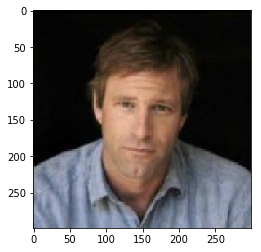

In [9]:
img = load_image('../../datasets/private_proof_v1/dev/1_face/Aaron_Eckhart_0001.jpg', desired_image_size)
plt.imshow(img)

In [10]:
# Look, it got it right!

print(sess.run(preds, feed_dict={x: np.asarray([img])})[0])
print(np.argmax(sess.run(preds, feed_dict={x: np.asarray([img])})))

[0.00740103 0.992599  ]
1


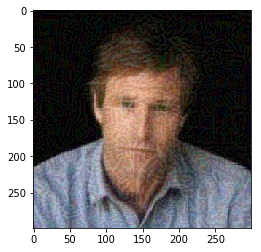

In [11]:
perturbed_img_weak = sess.run(adv_x_weak, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_weak)

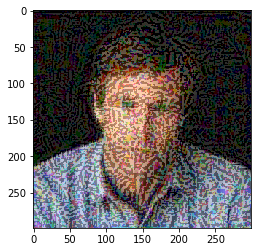

In [12]:
perturbed_img_strong = sess.run(adv_x_strong, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_strong)

In [13]:
def attack_images(imgs, adv_x):
    imgs = np.asarray(imgs)
    assert len(imgs.shape) == 4
    assert imgs.shape[1] == imgs.shape[2] == desired_image_size[0]
    assert imgs.shape[3] == 3
    assert (0.0 <= imgs).all() and (imgs <= 1.0).all()
    return sess.run(adv_x, feed_dict={x: imgs})

In [14]:
# Look, it got it wrong on the weak attack!

perturbed_img = attack_images([img], adv_x=adv_x_weak)[0]

print(sess.run(preds, feed_dict={x: np.asarray([perturbed_img])})[0])
print(np.argmax(sess.run(preds, feed_dict={x: np.asarray([perturbed_img])})))

[0.94774514 0.05225486]
0


In [15]:
# Look, it got it wrong on the strong attack!

perturbed_img = attack_images([img], adv_x=adv_x_strong)[0]

print(sess.run(preds, feed_dict={x: np.asarray([perturbed_img])})[0])
print(np.argmax(sess.run(preds, feed_dict={x: np.asarray([perturbed_img])})))

[0.95764095 0.04235909]
0


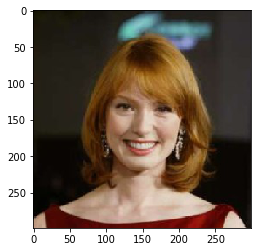

In [16]:
img = load_image('../../datasets/private_proof_v1/dev/1_face/Alicia_Witt_0001.jpg', desired_image_size)
plt.imshow(img)

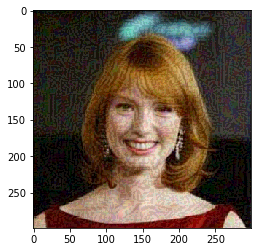

In [17]:
perturbed_img_weak = sess.run(adv_x_weak, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_weak)

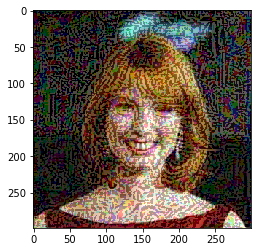

In [18]:
perturbed_img_strong = sess.run(adv_x_strong, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_strong)

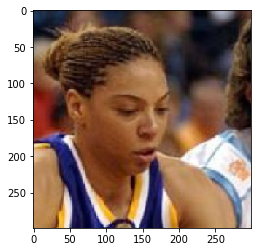

In [19]:
img = load_image('../../datasets/private_proof_v1/dev/1_face/Aiysha_Smith_0001.jpg', desired_image_size)
plt.imshow(img)

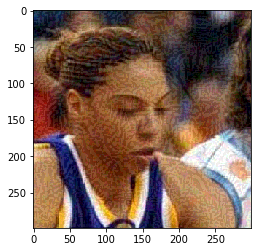

In [20]:
perturbed_img_weak = sess.run(adv_x_weak, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_weak)

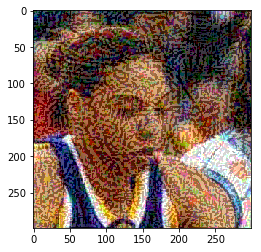

In [21]:
perturbed_img_strong = sess.run(adv_x_strong, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_strong)

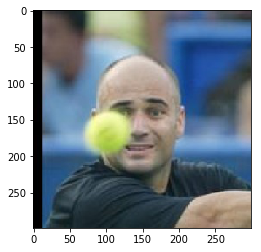

In [22]:
img = load_image('../../datasets/private_proof_v1/dev/1_face/Andre_Agassi_0020.jpg', desired_image_size)
plt.imshow(img)

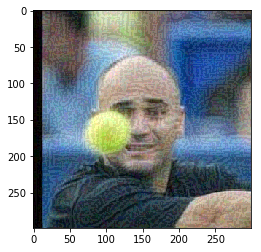

In [23]:
perturbed_img_weak = sess.run(adv_x_weak, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_weak)

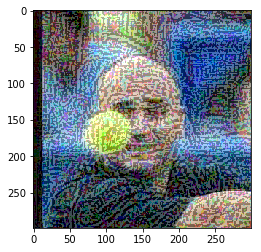

In [24]:
perturbed_img_strong = sess.run(adv_x_strong, feed_dict={x: np.asarray([np.asarray(img)])})[0]
plt.imshow(perturbed_img_strong)

# Create a detector from our subsitution model

In [25]:
from face_detectors.face_detector import FaceDetector

In [26]:
class SubsitutionWhitebox(FaceDetector):
    
    def _detect_face(self, img):
        return np.argmax(sess.run(preds, feed_dict={x: np.asarray([img])})) == 1

In [27]:
sub_wb_detector = SubsitutionWhitebox()

In [28]:
# Look, it got it right!

img = load_image('../../datasets/private_proof_v1/dev/1_face/Aaron_Eckhart_0001.jpg', desired_image_size)

sub_wb_detector.contains_a_face(img)

True

In [29]:
# Look, it got it wrong!

perturbed_img = attack_images([img], adv_x=adv_x_strong)[0]

sub_wb_detector.contains_a_face(perturbed_img)

False

# Evaluate remote API face detectors against our image attack

In [30]:
import io

from PIL import Image as pil_image
from google.cloud import vision
from google.cloud.vision import types
from clarifai.rest import ClarifaiApp
from clarifai.rest import Image as ClImage

from face_detectors.face_detector import FaceDetector

In [31]:
class GoogleVisionFaceDetector(FaceDetector):
    
    _client = vision.ImageAnnotatorClient()
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        pil_image.fromarray(np.uint8(img * 255.0)).save(bytes_buff, 'PNG')
        img_byte_array = bytes_buff.getvalue()

        # Request
        image = types.Image(content=img_byte_array)
        response = self._client.face_detection(image=image)        
        return len(response.face_annotations) > 0
    
class ClarifaiFaceDetector(FaceDetector):
    
#     _app = ClarifaiApp(api_key='f9c874a9098c4ade9ea857a4b955cee0')
    _app = ClarifaiApp(api_key='cf758cd9528f436c9e63d5b083cdd650')
    _model = _app.models.get("face-v1.3")
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        pil_image.fromarray(np.uint8(img * 255.0)).save(bytes_buff, 'PNG')

        # Request
        image = ClImage(file_obj=bytes_buff)
        results2 = clarifai_vision_detector._model.predict([image])
        return 'regions' in results2['outputs'][0]['data']
    
class ClarifaiFaceDetector(FaceDetector):
    
#     _app = ClarifaiApp(api_key='f9c874a9098c4ade9ea857a4b955cee0')
    _app = ClarifaiApp(api_key='cf758cd9528f436c9e63d5b083cdd650')
    _model = _app.models.get("face-v1.3")
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        pil_image.fromarray(np.uint8(img * 255.0)).save(bytes_buff, 'PNG')

        # Request
        image = ClImage(file_obj=bytes_buff)
        results2 = clarifai_vision_detector._model.predict([image])
        return 'regions' in results2['outputs'][0]['data']

In [32]:
gc_vision_detector = GoogleVisionFaceDetector()
clarifai_vision_detector = ClarifaiFaceDetector()

In [33]:
# Look, it got it right!

img = load_image('../../datasets/private_proof_v1/dev/1_face/Aaron_Eckhart_0001.jpg', desired_image_size)

gc_vision_detector.contains_a_face(img)

True

In [34]:
# Look, it got it wrong!

perturbed_img = attack_images([img], adv_x=adv_x_strong)[0]

gc_vision_detector.contains_a_face(perturbed_img)

False

In [35]:
# Look, it got it right!

img = load_image('../../datasets/private_proof_v1/dev/1_face/Aaron_Eckhart_0001.jpg', desired_image_size)

clarifai_vision_detector.contains_a_face(img)

True

In [36]:
# Look, it got it wrong!

perturbed_img = attack_images([img], adv_x=adv_x_strong)[0]

clarifai_vision_detector.contains_a_face(perturbed_img)

False

# Evaluate the subsitution model, the local blackbox face detectors, and Google Cloud Vision's API against our image attack

In [37]:
import sys
sys.path.append('../../source')

from pathlib import Path
import cv2
from IPython.display import Image, display
import dlib
import pandas as pd

from data_processing import import_images_from_directories
from face_detectors import dlib_face_detector, cv2_cascade_face_detector

In [38]:
dataset_path = '../../datasets/private_proof_v1/dev'

In [39]:
detectors = {
    'sub_wb': SubsitutionWhitebox(),
    'dlib': dlib_face_detector.DlibFaceDetector(), 
    'cv2': cv2_cascade_face_detector.CV2CascadeFaceDetector(),
    'gc_vision': GoogleVisionFaceDetector(),
    'clarifai': ClarifaiFaceDetector()
}

In [40]:
def detections(detectors, X):
    num_dets = {}
    for name, d in detectors.items():
        num_dets[name] = d.contains_a_face(X).sum()
    return num_dets, X.shape[0]

In [41]:
max_images_per_class = 50

index = pd.Index(['sub_wb_face_detections-as_%', 'dlib_face_detections-as_%', 'cv2_face_detections-as_%', 'gc_vision_face_detections-as_%', 'clarifai_face_detections-as_%'])
confusion = pd.DataFrame(index=index, columns=['0_nonface', '1_face', 'weak_fgsm_sub_wb-1_face', 'strong_fgsm_sub_wb-1_face'])
for c in confusion.columns:
    if c == 'weak_fgsm_sub_wb-1_face':
        X, _ = import_images_from_directories(dataset_path, class_labels=['1_face'], resize_shape=desired_image_size, max_images_per_class=max_images_per_class)
        X = attack_images(X, adv_x=adv_x_weak)
    elif c == 'strong_fgsm_sub_wb-1_face':
        X, _ = import_images_from_directories(dataset_path, class_labels=['1_face'], resize_shape=desired_image_size, max_images_per_class=max_images_per_class)
        X = attack_images(X, adv_x=adv_x_strong)
    else:
        X, _ = import_images_from_directories(dataset_path, class_labels=[c], resize_shape=desired_image_size, max_images_per_class=max_images_per_class)
    num_dets, total = detections(detectors, X)
    for key, val in num_dets.items():
        confusion.loc[key + '_face_detections-as_%', c] = 100.0 * val / total
        
confusion

Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_0.jpg, skipping...
Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_101.jpg, skipping...
Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_111.jpg, skipping...
Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_121.jpg, skipping...
Unable to open file ../../datasets/private_proof_v1/dev/0_nonface/ring_13.jpg, skipping...
The labels are: {0: '0_nonface'}


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


The labels are: {0: '1_face'}
The labels are: {0: '1_face'}
The labels are: {0: '1_face'}


,0_nonface,1_face,weak_fgsm_sub_wb-1_face,strong_fgsm_sub_wb-1_face
sub_wb_face_detections-as_%,0,100,2,0
dlib_face_detections-as_%,0,100,90,26
cv2_face_detections-as_%,13.3333,98,100,92
gc_vision_face_detections-as_%,0,100,96,8
clarifai_face_detections-as_%,0,100,80,4


# TODO

* Move this to colab
* Automated data packaging
* Move training to Google Cloud ML Engine
* Imbalanced classes
* No test dataset

export GOOGLE_APPLICATION_CREDENTIALS="/home/josh/repos/assembly_melt/MELT-3265e45c6462.json"